In [2]:
import numpy as np
import pandas as pd
import os
import cv2
import random
import matplotlib.pyplot as plt
import seaborn as sns


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing import image
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import accuracy_score, classification_report
from tqdm import tqdm

In this notebook we will train our model using the GPU resource provided by Kaggle

In [3]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [4]:
# Define path to the data directory

dir_alldata = "/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray"

# Path to train directory (Fancy pathlib...no more os.path!!)
train_data_dir = dir_alldata +'/train'

# Path to validation directory
validation_data_dir = dir_alldata + '/val'

# Path to test directory
test_data_dir = dir_alldata +'/test'

# Get the path to the normal and pneumonia sub-directories
normal_cases_train = train_data_dir + '/NORMAL'
pneumonia_cases_train = train_data_dir + '/PNEUMONIA'

IMAGE_SIZE = (200, 200)

In [5]:
IMAGE_SIZE

(200, 200)

In [6]:
def load_images(path):
    images = []
    labels = []
    
    for folder in os.listdir(path):
        
            label = folder
            
            # Iterate through each image in our folder
            if os.path.isdir(os.path.join(path, folder)):
                for file in tqdm(os.listdir(os.path.join(path, folder))):

                    if "jpeg" in file:
                        # Get the path name of the image
                        img_path = os.path.join(os.path.join(path, folder), file)

                        # Open and resize the img
                        image = cv2.imread(img_path)
                        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                        image = cv2.resize(image, IMAGE_SIZE) 

                        # Append the image and its corresponding label to the output
                        images.append(image)
                        labels.append(label)
                
    images = np.array(images, dtype = 'float32')

    return images, labels
    

In [7]:
train_X_set, train_y = load_images(train_data_dir)
test_X_set , test_y= load_images(test_data_dir)
validation_X_set, validation_y = load_images(validation_data_dir)

100%|██████████| 9/9 [00:00<00:00, 47.25it/s]


Normalize the values between 0 and 1 

In [8]:
train_X_set = train_X_set / 255
test_X_set = test_X_set / 255
validation_X_set = validation_X_set / 255

Visaulize the random images from the trainset

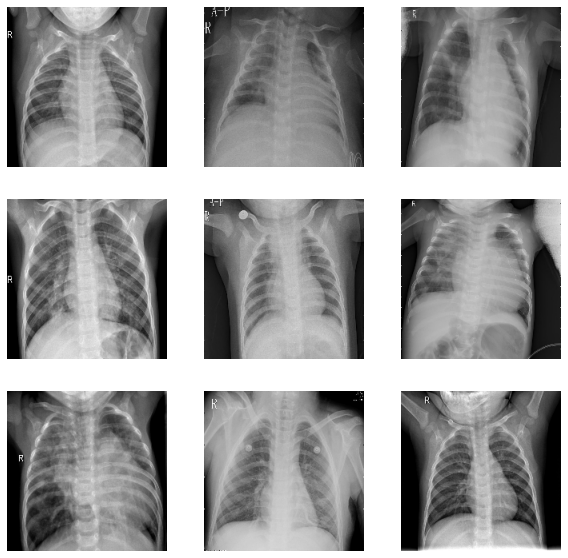

In [9]:
plt.figure(figsize=(10,10))
for i in range(1,10):
  plt.subplot(3,3,i)
  random_num = np.random.randint(0,len(train_X_set))
  plt.imshow(train_X_set[random_num][:,:,:])
  plt.grid(False)
  plt.axis('off')

Lets also check the distribution of both the normal xrays and those that show pneumonia 

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:ylabel='count'>

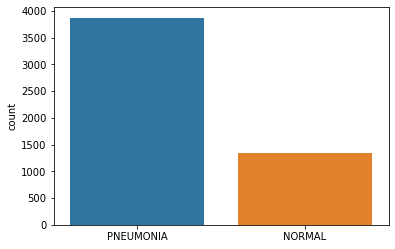

In [10]:
sns.countplot(train_y)

We saw earlier in this notebook that the data was imbalanced, with more images classified as pneumonia than normal. We will correct for that in this following section.

In [11]:
def encode_label(x):
    if x == "NORMAL":
        return 0.0
    return 1.0

In [12]:
train_y

['PNEUMONIA',
 'PNEUMONIA',
 'PNEUMONIA',
 'PNEUMONIA',
 'PNEUMONIA',
 'PNEUMONIA',
 'PNEUMONIA',
 'PNEUMONIA',
 'PNEUMONIA',
 'PNEUMONIA',
 'PNEUMONIA',
 'PNEUMONIA',
 'PNEUMONIA',
 'PNEUMONIA',
 'PNEUMONIA',
 'PNEUMONIA',
 'PNEUMONIA',
 'PNEUMONIA',
 'PNEUMONIA',
 'PNEUMONIA',
 'PNEUMONIA',
 'PNEUMONIA',
 'PNEUMONIA',
 'PNEUMONIA',
 'PNEUMONIA',
 'PNEUMONIA',
 'PNEUMONIA',
 'PNEUMONIA',
 'PNEUMONIA',
 'PNEUMONIA',
 'PNEUMONIA',
 'PNEUMONIA',
 'PNEUMONIA',
 'PNEUMONIA',
 'PNEUMONIA',
 'PNEUMONIA',
 'PNEUMONIA',
 'PNEUMONIA',
 'PNEUMONIA',
 'PNEUMONIA',
 'PNEUMONIA',
 'PNEUMONIA',
 'PNEUMONIA',
 'PNEUMONIA',
 'PNEUMONIA',
 'PNEUMONIA',
 'PNEUMONIA',
 'PNEUMONIA',
 'PNEUMONIA',
 'PNEUMONIA',
 'PNEUMONIA',
 'PNEUMONIA',
 'PNEUMONIA',
 'PNEUMONIA',
 'PNEUMONIA',
 'PNEUMONIA',
 'PNEUMONIA',
 'PNEUMONIA',
 'PNEUMONIA',
 'PNEUMONIA',
 'PNEUMONIA',
 'PNEUMONIA',
 'PNEUMONIA',
 'PNEUMONIA',
 'PNEUMONIA',
 'PNEUMONIA',
 'PNEUMONIA',
 'PNEUMONIA',
 'PNEUMONIA',
 'PNEUMONIA',
 'PNEUMONIA',
 'PNEU

In [13]:
train_y = [encode_label(i) for i in train_y]
test_y = [encode_label(i) for i in test_y]
validation_y = [encode_label(i) for i in validation_y]

In [14]:
train_y = np.array(train_y)
test_y = np.array(test_y)
validation_y = np.array(validation_y)


In [15]:
input_shape =(200, 200,3)
nb_train_sample =1000
nb_validation_samples =100

epochs = 50
batch_size = 20

#Data Augementation


train_datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)


train_generator= train_datagen.fit(train_X_set)



In [45]:
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=10, verbose=1, mode='auto',
        restore_best_weights=True)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 5, verbose=1,factor=0.3, mode="max")
callback_list = [monitor, learning_rate_reduction]


model = Sequential()
model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (200,200,3)))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Flatten())
model.add(Dense(units = 128 , activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(units = 1 , activation = 'sigmoid'))
model.compile(optimizer = "adam" , loss = 'binary_crossentropy' , metrics = ['accuracy',tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')])
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 200, 200, 32)      896       
_________________________________________________________________
batch_normalization_20 (Batc (None, 200, 200, 32)      128       
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 100, 100, 32)      0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 100, 100, 64)      18496     
_________________________________________________________________
dropout_21 (Dropout)         (None, 100, 100, 64)      0         
_________________________________________________________________
batch_normalization_21 (Batc (None, 100, 100, 64)      256       
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 50, 50, 64)       

In [46]:

history = model.fit(train_datagen.flow(train_X_set, train_y, batch_size = 64) ,epochs = 100 , \
                    validation_data = train_datagen.flow(validation_X_set, validation_y) ,callbacks = callback_list)

Epoch 1/100
82/82 [==============================] - 45s 529ms/step - loss: 1.0557 - accuracy: 0.8042 - precision: 0.8801 - recall: 0.8469 - val_loss: 17.8601 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 1.0000
Epoch 2/100
82/82 [==============================] - 44s 531ms/step - loss: 0.1993 - accuracy: 0.9240 - precision: 0.9475 - recall: 0.9496 - val_loss: 21.2920 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 1.0000
Epoch 3/100
82/82 [==============================] - 43s 524ms/step - loss: 0.1835 - accuracy: 0.9340 - precision: 0.9574 - recall: 0.9540 - val_loss: 23.7620 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 1.0000
Epoch 4/100
82/82 [==============================] - 43s 522ms/step - loss: 0.1569 - accuracy: 0.9487 - precision: 0.9619 - recall: 0.9678 - val_loss: 16.3991 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 1.0000
Epoch 5/100
82/82 [==============================] - 43s 525ms/step - loss: 0.1411 - accurac

In [18]:
def plot_validation_curves(result):
  result = pd.DataFrame(result)
  fig, axs = plt.subplots(1,2)
  result[['loss','val_loss']].plot(figsize=(10, 3),ax=axs[0])
  axs[0].set_title('Train vs validation Loss')
  axs[0].set_xlabel('Epochs')
  axs[0].set_ylabel('Loss')
  result[['accuracy','val_accuracy']].plot(figsize=(10, 3),ax=axs[1])
  axs[1].set_title('Train vs validation Accuracy')
  axs[1].set_xlabel('Epochs')
  axs[1].set_ylabel('Accuracy')

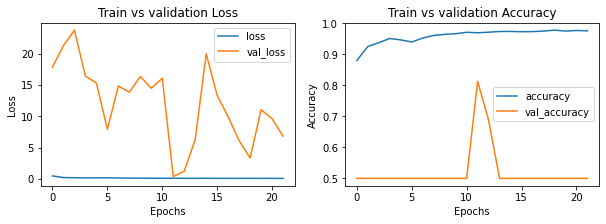

In [53]:
plot_validation_curves(history.history)

In [19]:
ANN_model = Sequential()

ANN_model.add(tf.keras.layers.Reshape((40000*3,), input_shape=(200,200,3)))
ANN_model.add(Dense(units=128,  activation='relu'))
ANN_model.add(Dropout(rate=0.2))

ANN_model.add(Dense(units=128, activation='relu'))
ANN_model.add(Dropout(rate=0.2))

ANN_model.add(Dense(units=64,  activation='relu'))
ANN_model.add(Dropout(rate=0.2))

ANN_model.add(Dense(units=32, activation='relu'))
ANN_model.add(Dropout(rate=0.2))

ANN_model.add(Dense(units=16,  activation='relu'))
ANN_model.add(Dense(units=8, activation='relu'))
ANN_model.add(Dropout(rate=0.1))

ANN_model.add(Dense(units=1, activation='sigmoid'))

ANN_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 120000)            0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               15360128  
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout_5 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_6 (Dropout)          (None, 64)               

In [20]:
ANN_model.compile(loss = 'binary_crossentropy', optimizer='adam', metrics = ['accuracy',tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')])

In [23]:
train_datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)

validation_datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)




train_datagen.fit(train_X_set)

In [24]:
history = ANN_model.fit(train_datagen.flow(train_X_set, train_y, batch_size = 64) ,epochs = 100 , \
                    validation_data = train_datagen.flow(validation_X_set, validation_y) ,callbacks = callback_list)

Epoch 1/100
82/82 [==============================] - 43s 513ms/step - loss: 0.6068 - accuracy: 0.6948 - precision: 0.7447 - recall: 0.8940 - val_loss: 0.6945 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 1.0000
Epoch 2/100
82/82 [==============================] - 41s 505ms/step - loss: 0.4461 - accuracy: 0.7752 - precision: 0.7811 - recall: 0.9749 - val_loss: 0.7775 - val_accuracy: 0.6875 - val_precision: 0.6154 - val_recall: 1.0000
Epoch 3/100
82/82 [==============================] - 41s 500ms/step - loss: 0.3841 - accuracy: 0.8517 - precision: 0.8837 - recall: 0.9237 - val_loss: 0.6805 - val_accuracy: 0.6875 - val_precision: 0.6154 - val_recall: 1.0000
Epoch 4/100
82/82 [==============================] - 41s 495ms/step - loss: 0.3474 - accuracy: 0.8702 - precision: 0.8873 - recall: 0.9447 - val_loss: 0.9703 - val_accuracy: 0.6250 - val_precision: 0.5714 - val_recall: 1.0000
Epoch 5/100
82/82 [==============================] - 41s 499ms/step - loss: 0.3337 - accuracy: 0

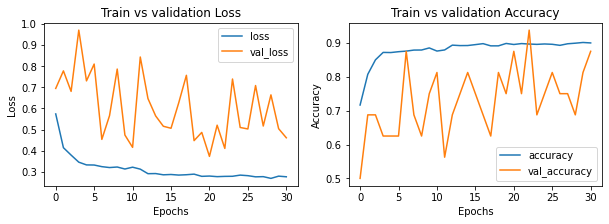

In [27]:
plot_validation_curves(history.history)

# Model Predictions

In [ ]:
ANN_model.evaluate(validation_X_set_2, np.array(validation_y))

In [62]:
 loss, accuracy, precision,recall = ANN_model.evaluate(test_X_set,test_y)


20/20 [==============================] - 0s 16ms/step - loss: 54.2098 - accuracy: 0.7804 - precision: 0.7495 - recall: 0.9744


In [63]:
 cnn_loss, cnn_accuracy, cnn_precision,cnn_recall = model.evaluate(test_X_set,test_y)

20/20 [==============================] - 0s 14ms/step - loss: 104.6303 - accuracy: 0.6667 - precision: 0.9740 - recall: 0.4795


In [64]:
loss

54.20980453491211

<AxesSubplot:>

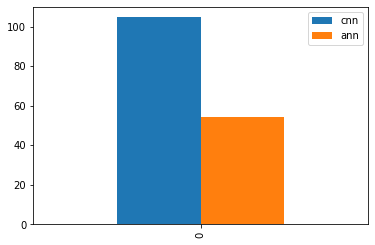

In [73]:
loss_dict = dict()
loss_dict ["cnn"] = cnn_loss
loss_dict ['ann'] = loss

pd.DataFrame(data = [loss_dict]).plot(kind="bar")

<AxesSubplot:>

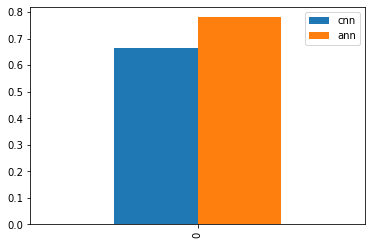

In [75]:
acc_dict = dict()
acc_dict ["cnn"] = cnn_accuracy
acc_dict ['ann'] = accuracy

pd.DataFrame(data = [acc_dict]).plot(kind="bar")

<AxesSubplot:>

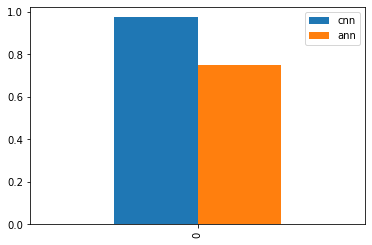

In [76]:
precision_dict = dict()
precision_dict ["cnn"] = cnn_precision
precision_dict ['ann'] = precision

pd.DataFrame(data = [precision_dict]).plot(kind="bar")

<AxesSubplot:>

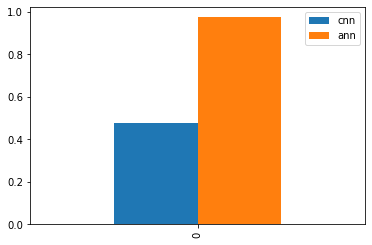

In [77]:
recall_dict = dict()
recall_dict ["cnn"] = cnn_recall
recall_dict ['ann'] = recall

pd.DataFrame(data = [recall_dict]).plot(kind="bar")